In [8]:
import os
import numpy as np
import torch
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from torchvision import transforms
from tqdm.notebook import tqdm 

TWOJ_KOD_TUTAJ = None 

def create_bbox_coords(bbox):
    xmin = float(bbox.find('xmin').text)
    ymin = float(bbox.find('ymin').text)
    xmax = float(bbox.find('xmax').text)
    ymax = float(bbox.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def create_mask(plasmodium_img, bbox):
    xmin, ymin, xmax, ymax = create_bbox_coords(bbox)
    mask = np.zeros((plasmodium_img.size[1], plasmodium_img.size[0]), dtype=np.uint8)
    mask[int(ymin):int(ymax), int(xmin):int(xmax)] = 1 
    return mask 

    
class MalariaPlasmodiumDataset(torch.utils.data.Dataset):
    # Będziemy czytać pliki jpg i odpowiadające im pliki XML 
    # z katalogu directory_root 
    # Podamy też transformacje jakie chcemy przeprowadzać na zwracanych wartościach 
    
    def __init__(self, directory_root, images_transforms=None):

        # Przypisujemy parametetry konstruktora do self 
        # Chcemy aby nasz przyszły obiekt wiedzial o tym gdzie szukać plików oraz 
        # jakie transformacje wykonywać na przeczytanych JPG 
        self.directory_root = directory_root        
        self.images_transforms = images_transforms

        # Listujemy wszystkie pliki które mają rozszerzenie "JPG" 
        self.all_image_files = sorted([img for img in os.listdir(directory_root) if img.endswith(".jpg")])
        
    def __getitem__(self, idx: int):
        # "magiczna" metoda __getitem__ jest wykorzystywana kiedy chcemy aby nasz obiekt był dostępny poprzez operator [int] 
        # podobnie jak lista czy dict 
        single_plasmodium_img_path = self.get_single_plasmodium_path(idx)
        single_annotation_file_path = single_plasmodium_img_path.replace(".jpg", ".xml")
        plasmodium_img = Image.open(single_plasmodium_img_path).convert("RGB") 
        
        # read xml file
        annotations = ET.parse(single_annotation_file_path)
        boxes = []
        masks = []        
        
        for detected_plasmodium in annotations.findall('object'):            
            bbox = detected_plasmodium.find('bndbox')
            boxes.append(
                create_bbox_coords(bbox)
            )
        
            masks.append(
                create_mask(
                    plasmodium_img, bbox
                )
            )
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)  

        image_id = torch.tensor([idx])
        labels = torch.ones((len(boxes),), dtype=torch.int64)              
        
        if self.images_transforms is not None:
            transformed_plasmodium_img = self.images_transforms(plasmodium_img)
        else:
            transformed_plasmodium_img = plasmodium_img
            
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id        
        target["masks"] = masks
        
        return transformed_plasmodium_img, target

    def get_single_plasmodium_path(self, idx):
        single_plasmodium_img_path = os.path.join(self.directory_root, self.all_image_files[idx])
        return single_plasmodium_img_path
    
    def __len__(self):
        # magiczna metoda __len__ jest używana gdy na instancji wykonujemy len() 
        return len(self.all_image_files)

    def draw(self, sample_id: int, color = (255,0,0)):    
        image_path = self.get_single_plasmodium_path(self[sample_id][1]['image_id'])
        bboxes = self[sample_id][1]['boxes']
        img_pil = Image.open(image_path)        
        draw = ImageDraw.Draw(img_pil)
    
        for i, box in enumerate(bboxes):
            xmin, ymin, xmax, ymax = box                    
            draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)        
        return img_pil 

In [9]:
# TODO: 

dataset = MalariaPlasmodiumDataset("plasmodium-phonecamera/train")

# utwórz instancję klasy MalariaPlasmodiumDataset podając Twoją lokalną ścieżkę gdzie znajdują się rozpakowane dane jako directory_root 

In [10]:
len(dataset)

1005

In [58]:
# TODO: ile obiektów znajduje się w datasecie ? 

In [11]:
# TODO: Ile wykrytych zarodźców znajduje się w datasecie ? 
total_sum = 0
for img, target in dataset:
    boxes = target['boxes']
    total_sum += len(boxes)

In [13]:
# TODO: Ile wykrytych zarodźców znajduje się w datasecie ? 
total_cases = 0 
for img, target in dataset:
    boxes = target['boxes']
    if len(boxes) > 0: 
        total_cases += 1 

In [17]:
len(dataset), total_cases

(1005, 803)

In [18]:
import pandas as pd 

In [19]:
counts = []
for img, target in dataset:
    boxes = target['boxes']
    counts.append(len(boxes))

<Axes: >

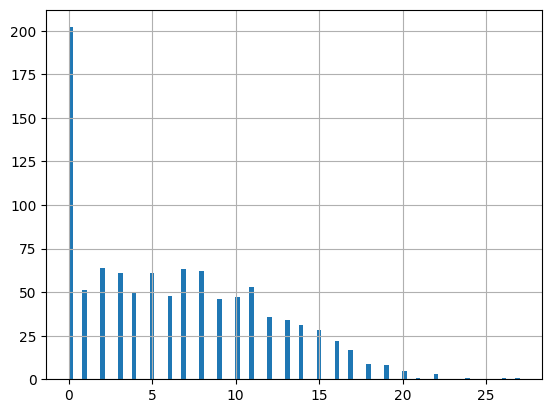

In [26]:
pd.Series(counts).hist(bins=100)

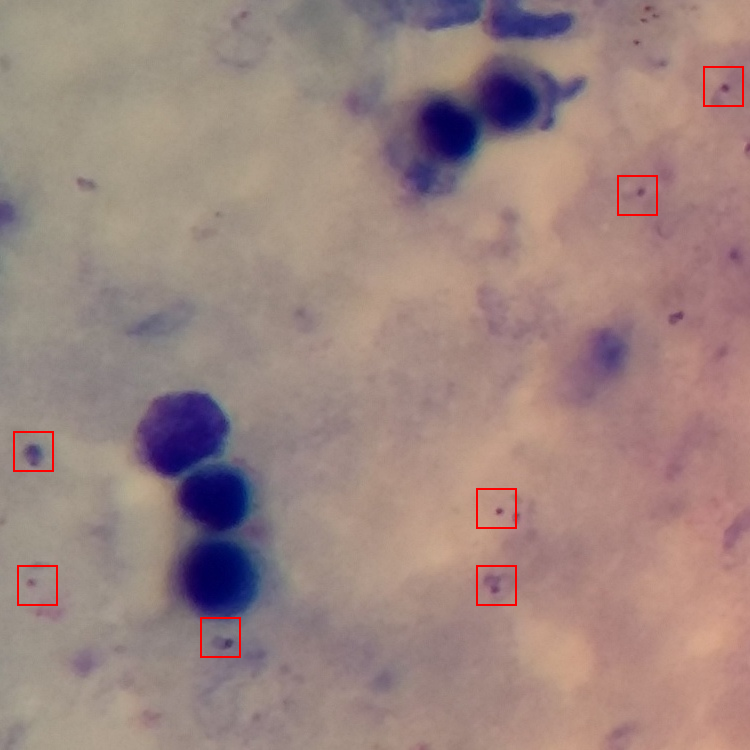

In [35]:
dataset.draw(2)

In [53]:
# TODO: użyj metody "draw" na instancji dataset aby zwizualizować kilka przykładowych sampli 